In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
from collections import Counter
import time
import random

import rdflib
import numpy as np
from pprint import pprint
from sklearn import svm

import wlkernel

In [3]:
rdf_graph = rdflib.Graph().parse('../data/Lexicon_NamedRockUnit.nt', format='nt')

In [4]:
all_triples = [
    (str(subj), str(pred), str(obj))
     for subj, pred, obj in rdf_graph
]

In [5]:
quantiles = np.linspace(0.1, 1, 10)  # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
results_wlrdf = []
results_wl = []
n = len(all_triples)
RANDOM_STATE = 42

In [6]:
for q in quantiles:
    n_sub = int(n * q)
    random.seed(RANDOM_STATE)
    triples = random.sample(all_triples, n_sub)
    
    instances_class_map = {
        subj: obj
        for subj, pred, obj in triples
        if 'hasLithogenesis' in pred
    }
    instances = list(instances_class_map.keys())
    y = list(instances_class_map.values())
    
    triples = [
        (subj, pred, obj)
        for subj, pred, obj in triples
        if 'hasLithogenesis' not in pred
    ]
    t0 = time.time()
    wlrdf_graph = wlkernel.WLRDFGraph(triples, instances, max_depth=3)
    kernel_matrix = wlkernel.wlrdf_kernel_matrix(wlrdf_graph, instances, iterations=0)
    t1 = time.time()

    results_wlrdf.append(t1 - t0)

In [7]:
rdf_graph = rdflib.Graph().parse('../data/Lexicon_NamedRockUnit.nt', format='nt')
all_triples = [
    (str(subj), str(pred), str(obj))
     for subj, pred, obj in rdf_graph
]

In [8]:
for q in quantiles:
    n_sub = int(n * q)
    random.seed(RANDOM_STATE)
    triples = random.sample(all_triples, n_sub)
    
    instances_class_map = {
        subj: obj
        for subj, pred, obj in triples
        if 'hasLithogenesis' in pred
    }
    instances = list(instances_class_map.keys())
    y = list(instances_class_map.values())
    
    triples = [
        (subj, pred, obj)
        for subj, pred, obj in triples
        if 'hasLithogenesis' not in pred
    ]
    t0 = time.time()
    wl_graphs = [wlkernel.WLGraph(triples, instance, max_depth=3) for instance in instances]
    kernel_matrix = wlkernel.wl_kernel_matrix(wl_graphs, iterations=0)
    t1 = time.time()

    results_wl.append(t1 - t0)

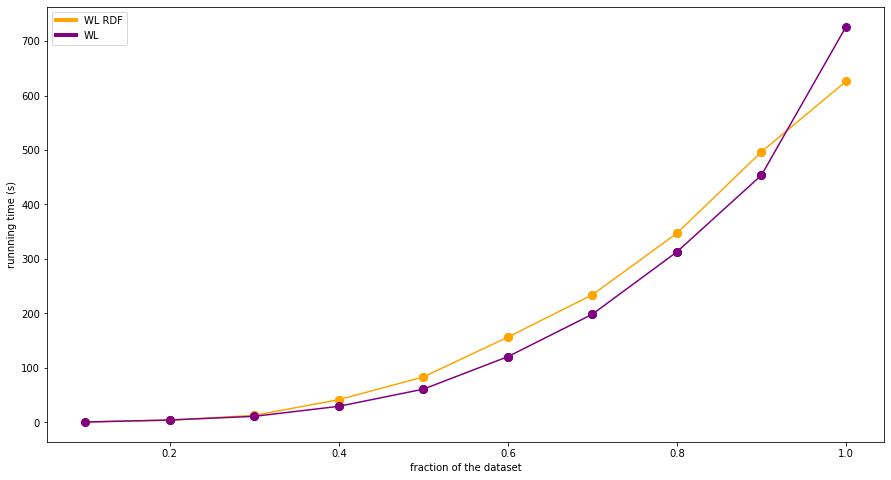

In [11]:
import matplotlib.pyplot as plt

class Result:
    def __init__(self, values = None, color = 'red', name = ''):
        if values is not None:
            self.values = values
        self.color = color
        self.name = name

x = quantiles
y = Result(results_wlrdf, 'orange', 'WL RDF')
y1 = Result(results_wl, 'purple', 'WL')
n = len(x)

fig, ax = plt.subplots(figsize=(15, 8))
for i in range(n - 1):
    plt.plot(x[i: i+2], y.values[i: i+2],
             'o-', color=y.color, markersize=8)
    plt.plot(x[i: i+2], y1.values[i: i+2],
             'o-', color= y1.color, markersize=8)

ax.xaxis.label.set_text('fraction of the dataset')
ax.yaxis.label.set_text('runnning time (s)')

custom_lines = [plt.Line2D([0], [0], color=y.color, lw=4),
                plt.Line2D([0], [0], color=y1.color, lw=4)]
ax.legend(custom_lines, [y.name, y1.name])
plt.savefig('../results/01-lithogenesis_timing.png', format='png')